# Order Predicitve modeling

This notebook demonstrates a step-by-step approach to creating a predictive model for forecasting orders for the month.

To guide the solution to the problem, I can start by addressing the following two principal questions:

1. What are the expected order days for each client?
2. How confident is the model built?



## Environment Setup

To begin the project, I created a Conda environment named `ps_bee` with Python 3.10. After setting up the environment, I installed the necessary packages listed in the `requirements.txt` file.

```bash
conda create --name ps_bee python=3.10
conda activate ps_bee
```

The `requirements.txt` file:
```text
pandas==2.2.2
numpy==2.1.0
ipykernel==6.29.5
pyarrow==17.0.0
fastparquet==2024.5.0
pandas-profiling==3.6.6
```

# Functions

This section organizes some functions that will be used throughout the code.


In [ ]:
import os
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import statsmodels
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

## Functions to date process

In [48]:
def calculate_period_columns(df, date_column="order_date"):
    """
    Calculate period columns for a DataFrame based on a custom date column.

    Args:
        df (pd.DataFrame): Input DataFrame with a date column.
        date_column (str): Name of the column containing date values.

    Returns:
        pd.DataFrame: DataFrame with additional period columns:
            - 'year': Year of the transaction
            - 'week_in_year': ISO week number in the year
            - 'month_in_year': Month number in the year
            - 'four_week_period': 4-week period within the year
            - 'year_four_week_period': Unique identifier for each 4-week period
    """
    df = df.reset_index()
    df[date_column] = pd.to_datetime(df[date_column])

    # Add columns for week_in_year, month_in_year, year, four_week_period, and year_four_week_period
    df['week_in_year'] = df[date_column].dt.isocalendar().week
    df['month_in_year'] = df[date_column].dt.month
    df['year'] = df[date_column].dt.year
    df['four_week_period'] = ((df['week_in_year'] - 1) // 4) + 1
    df['year_four_week_period'] = df['year'].astype(str) + '_W' + df['four_week_period'].astype(str)

    list_ordered_columns = [date_column, 'year', 'week_in_year', 'year_four_week_period', 'four_week_period','month_in_year']
    list_ordered_columns = [*list_ordered_columns, *[col for col in df.columns if col not in list_ordered_columns]]
    df = df[list_ordered_columns]

    return df


def calculate_remaning_orders_in_month(df):
    """
    Calculate the sum of distinct transaction values for each 4-week period,
    and compute the remaining orders in the period as a subtractive cumulative value.

    Args:
        df (pd.DataFrame): Input DataFrame with columns 'order_date', 'total_transaction_amount', and 'distinct_transaction_values'.

    Returns:
        pd.DataFrame: DataFrame with additional columns:
            - 'week_in_year': ISO week number in the year (starting with Monday)
            - 'month_in_year': Month number in the year
            - 'year': Year of the transaction
            - 'four_week_period': 4-week period within the year
            - 'year_four_week_period': Unique identifier for each 4-week period
            - 'orders_in_4w': Sum of distinct transaction values for each 4-week period
            - 'cumulative_sum': Cumulative sum of distinct transaction values within each 4-week period
            - 'remaining_orders_in_4w': Remaining orders in the 4-week period as subtractive cumulative
    """
    # Ensure 'order_date' is in datetime format
    df = df.reset_index()
    df['order_date'] = pd.to_datetime(df['order_date'])

    # Reindex to fill in all dates in the range with missing data filled with 0
    full_range = pd.date_range(start=df['order_date'].min(), end=df['order_date'].max(), freq='D')
    df = df.set_index('order_date').reindex(full_range, fill_value=0).rename_axis('order_date').reset_index()

    # Add columns for week_in_year and month_in_year
    df = calculate_period_columns(df)

    # Calculate the sum of distinct transaction values for each 4-week period
    period_sum = df.groupby('year_four_week_period')['distinct_transaction_values'].transform('sum')

    # Add the new columns to the dataframe
    df['orders_in_4w'] = period_sum

    # Calculate the cumulative sum of distinct_transaction_values within each 4-week period
    df['cumulative_sum'] = df.groupby('year_four_week_period')['distinct_transaction_values'].cumsum()

    # Calculate the remaining orders in the period as subtractive cumulative
    df['remaining_orders_in_4w'] = df['orders_in_4w'] - df['cumulative_sum']

    # Drop the temporary columns and retain relevant ones
    df = df.drop(columns="cumulative_sum")

    return df



# def plot_4week_period(df, value_column, settings, df_naive=None, df_true=None):
#     """
#     Plots the remaining orders in 4-week periods, optionally includes naive and true forecast data.

#     Parameters:
#     - df (pd.DataFrame): The dataframe containing the historical data.
#     - value_column (str): The column name for the values to plot.
#     - settings (dict): Dictionary containing settings for the plot. Must include:
#         - 'title': Title of the plot
#         - 'xlabel': Label for the x-axis
#         - 'ylabel': Label for the y-axis
#     - df_naive (pd.DataFrame, optional): The dataframe containing naive forecast data. If provided, it will be plotted with a different style.
#     - df_true (pd.DataFrame, optional): The dataframe containing true forecast data. If provided, it will be plotted with a different style.

#     Raises:
#     - ValueError: If 'order_date' or 'year_four_week_period' columns are not present in the dataframe.
#     """

#     # Check if required columns are in the dataframe
#     required_columns = ['order_date', 'year_four_week_period']
#     for col in required_columns:
#         if col not in df.columns:
#             raise ValueError(f"Missing required column: {col}")

#     if value_column not in df.columns:
#         raise ValueError(f"Missing column for values to plot: {value_column}")

#     # Create combined dataframe with historical, naive, and true forecast data
#     df_combined = df.copy()

#     if df_naive is not None:
#         if not {'order_date', 'year_four_week_period', value_column}.issubset(df_naive.columns):
#             raise ValueError(f"Naive DataFrame must contain 'order_date', 'year_four_week_period', and the column {value_column}.")
#         df_combined = pd.concat([df_combined, df_naive], axis=0)

#     if df_true is not None:
#         if not {'order_date', 'year_four_week_period', value_column}.issubset(df_true.columns):
#             raise ValueError(f"True DataFrame must contain 'order_date', 'year_four_week_period', and the column {value_column}.")
#         df_combined = pd.concat([df_combined, df_true], axis=0)

#     # Plot remaining orders as a line chart
#     fig, ax1 = plt.subplots(figsize=(14, 6))

#     # Plot the historical data
#     df[df['order_date'].notna()].set_index('order_date')[value_column].plot(kind='line', ax=ax1, color='b', label='Historical Data', title=settings['title'])

#     # Plot the naive forecast data if available
#     if df_naive is not None:
#         df_naive[df_naive['order_date'].notna()].set_index('order_date')[value_column].plot(kind='line', ax=ax1, color='r', linestyle='--', linewidth=0.7, label='Naive Forecast')

#     # Plot the true forecast data if available
#     if df_true is not None:
#         df_true[df_true['order_date'].notna()].set_index('order_date')[value_column].plot(kind='line', ax=ax1, color='g', linestyle='-', linewidth=1.1, label='True Forecast')

#     # Add vertical dashed lines for the start of each 4-week period from the combined data
#     periods = df_combined['year_four_week_period'].drop_duplicates().sort_values()
#     for period in periods:
#         start_date = df_combined[df_combined['year_four_week_period'] == period]['order_date'].min()
#         ax1.axvline(x=start_date, color='gray', linestyle='--', linewidth=0.7)

#     # Create a secondary x-axis to show week numbers based on combined periods
#     ax2 = ax1.twiny()
#     ax2.set_xlim(ax1.get_xlim())
#     unique_periods = df_combined['year_four_week_period'].drop_duplicates().sort_values()
#     period_ticks = unique_periods
#     period_labels = [f'{str(p).split("_")[-1]}' for p in period_ticks]

#     ax2.set_xticks([df_combined[df_combined['year_four_week_period'] == p]['order_date'].min() for p in period_ticks])
#     ax2.set_xticklabels(period_labels, rotation=45)
#     ax2.set_xlabel('4-Week Period')

#     # Set title and labels
#     ax1.set_title(settings['title'])
#     ax1.set_xlabel(settings['xlabel'])
#     ax1.set_ylabel(settings['ylabel'])

#     # Remove top and right spines
#     ax1.spines[['top', 'right']].set_visible(False)

#     # Show legend if naive or true forecast data is plotted
#     if df_naive is not None or df_true is not None:
#         ax1.legend()

#     plt.show()

import pandas as pd
import matplotlib.pyplot as plt

def plot_4week_period(df, value_column, settings, df_naive=None, df_true=None, df_predict=None):
    """
    Plots the remaining orders in 4-week periods, optionally includes naive, true, and prediction data.

    Parameters:
    - df (pd.DataFrame): The dataframe containing the historical data.
    - value_column (str): The column name for the values to plot.
    - settings (dict): Dictionary containing settings for the plot. Must include:
        - 'title': Title of the plot
        - 'xlabel': Label for the x-axis
        - 'ylabel': Label for the y-axis
    - df_naive (pd.DataFrame, optional): The dataframe containing naive forecast data. If provided, it will be plotted with a different style.
    - df_true (pd.DataFrame, optional): The dataframe containing true forecast data. If provided, it will be plotted with a different style.
    - df_predict (pd.DataFrame, optional): The dataframe containing prediction data. If provided, it will be plotted with a solid red line.

    Raises:
    - ValueError: If 'order_date' or 'year_four_week_period' columns are not present in the dataframe.
    """

    # Check if required columns are in the dataframe
    required_columns = ['order_date', 'year_four_week_period']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    if value_column not in df.columns:
        raise ValueError(f"Missing column for values to plot: {value_column}")

    # Create combined dataframe with historical, naive, true forecast, and prediction data
    df_combined = df.copy()

    if df_naive is not None:
        if not {'order_date', 'year_four_week_period', value_column}.issubset(df_naive.columns):
            raise ValueError(f"Naive DataFrame must contain 'order_date', 'year_four_week_period', and the column {value_column}.")
        df_combined = pd.concat([df_combined, df_naive], axis=0)

    if df_true is not None:
        if not {'order_date', 'year_four_week_period', value_column}.issubset(df_true.columns):
            raise ValueError(f"True DataFrame must contain 'order_date', 'year_four_week_period', and the column {value_column}.")
        df_combined = pd.concat([df_combined, df_true], axis=0)

    if df_predict is not None:
        if not {'order_date', 'year_four_week_period', value_column}.issubset(df_predict.columns):
            raise ValueError(f"Predict DataFrame must contain 'order_date', 'year_four_week_period', and the column {value_column}.")
        df_combined = pd.concat([df_combined, df_predict], axis=0)

    # Plot remaining orders as a line chart
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot the historical data
    df[df['order_date'].notna()].set_index('order_date')[value_column].plot(kind='line', ax=ax1, color='b', label='Historical Data', title=settings['title'])

    # Plot the naive forecast data if available
    if df_naive is not None:
        df_naive[df_naive['order_date'].notna()].set_index('order_date')[value_column].plot(kind='line', ax=ax1, color='r', linestyle='--', linewidth=0.7, label='Naive Forecast')

    # Plot the true forecast data if available
    if df_true is not None:
        df_true[df_true['order_date'].notna()].set_index('order_date')[value_column].plot(kind='line', ax=ax1, color='g', linestyle='-', linewidth=1.1, label='True Forecast')

    # Plot the prediction data if available
    if df_predict is not None:
        df_predict[df_predict['order_date'].notna()].set_index('order_date')[value_column].plot(kind='line', ax=ax1, color='r', linestyle='-', linewidth=1.1, label='Prediction')

    # Add vertical dashed lines for the start of each 4-week period from the combined data
    periods = df_combined['year_four_week_period'].drop_duplicates().sort_values()
    for period in periods:
        start_date = df_combined[df_combined['year_four_week_period'] == period]['order_date'].min()
        ax1.axvline(x=start_date, color='gray', linestyle='--', linewidth=0.7)

    # Create a secondary x-axis to show week numbers based on combined periods
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    unique_periods = df_combined['year_four_week_period'].drop_duplicates().sort_values()
    period_ticks = unique_periods
    period_labels = [f'{str(p).split("_")[-1]}' for p in period_ticks]

    ax2.set_xticks([df_combined[df_combined['year_four_week_period'] == p]['order_date'].min() for p in period_ticks])
    ax2.set_xticklabels(period_labels, rotation=45)
    ax2.set_xlabel('4-Week Period')

    # Set title and labels
    ax1.set_title(settings['title'])
    ax1.set_xlabel(settings['xlabel'])
    ax1.set_ylabel(settings['ylabel'])

    # Remove top and right spines
    ax1.spines[['top', 'right']].set_visible(False)

    # Show legend if any forecast or prediction data is plotted
    if df_naive is not None or df_true is not None or df_predict is not None:
        ax1.legend()

    plt.show()


def generate_naive_forecast(df, period_value, period_type):
    """
    Generate a naive forecast by repeating the last known values for a specified period.

    Parameters:
    - df (pd.DataFrame): The dataframe containing the historical data.
    - period_value (int): The number of periods to forecast.
    - period_type (str): Type of period ('days', 'weeks', 'months').

    Returns:
    - pd.DataFrame: DataFrame containing the forecasted values with future dates.
    """

    # Validate period_type
    if period_type not in ['days', 'weeks', 'months']:
        raise ValueError("Invalid period_type. Must be 'days', 'weeks', or 'months'.")

    # Determine the end date of the forecast
    last_date = df['order_date'].max()

    # Calculate the period duration
    if period_type == 'days':
        period_duration = pd.Timedelta(days=period_value)
    elif period_type == 'weeks':
        period_duration = pd.Timedelta(weeks=period_value)
    elif period_type == 'months':
        period_duration = pd.DateOffset(months=period_value)

    # Generate the forecast dates
    forecast_end_date = last_date + period_duration
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), end=forecast_end_date)

    # Get the last known data points
    last_data_points = df.iloc[-len(forecast_dates):].copy()

    # Ensure the length of last_data_points matches the length of forecast_dates
    if len(last_data_points) < len(forecast_dates):
        # Repeat the last available data points if necessary
        repeats_needed = len(forecast_dates) - len(last_data_points)
        last_data_points = pd.concat([last_data_points] * (repeats_needed // len(last_data_points) + 1), ignore_index=True).head(len(forecast_dates))

    # Create a DataFrame for the forecasted period with period columns
    forecast_df = pd.DataFrame({
        'order_date': forecast_dates,
        'ref': [(row['order_date'], row['year_four_week_period']) for _, row in last_data_points.iterrows()]
    })

    last_data_points['ref'] = [(row['order_date'], row['year_four_week_period']) for _, row in last_data_points.iterrows()]
    last_data_points['order_date'] = forecast_dates


    # # Calculate period columns for forecast_df
    forecast_df = calculate_period_columns(last_data_points)


    return forecast_df



## Function to ETL data

In [13]:
# Define ETL functions
def ETL_august_total_sales(file_path: str) -> pd.DataFrame:
    """
    Extracts, transforms, and loads data from the specified parquet file.

    :param file_path: Path to the parquet file for August total sales.
    :return: DataFrame containing the data from the parquet file.
    """
    df_read = pd.read_parquet(file_path)
    return df_read

def ETL_august_with_missing_order_days(file_path: str) -> pd.DataFrame:
    """
    Extracts, transforms, and loads data from the specified parquet file.

    :param file_path: Path to the parquet file for August with missing order days.
    :return: DataFrame containing the data from the parquet file.
    """
    df_read = pd.read_parquet(file_path)
    return df_read

def ETL_historical_orders(file_path: str) -> pd.DataFrame:
    """
    Extracts, transforms, and loads data from the specified parquet file.

    :param file_path: Path to the parquet file for historical orders.
    :return: DataFrame containing the data from the parquet file.
    """
    df_read = pd.read_parquet(file_path)
    return df_read


# Generate profiling reports
def generate_profile_report(df: pd.DataFrame, file_name: str):
    """
    Generates a pandas profiling report for the given DataFrame and saves it to an HTML file.

    :param df: DataFrame to profile.
    :param file_name: Name of the output HTML file for the profiling report.
    """
    profile = ProfileReport(df, title=file_name, explorative=True)
    profile.to_file(file_name)



def process_historical_orders(df_august: pd.DataFrame, df_historical: pd.DataFrame) -> pd.DataFrame:
    """
    Concatenates two DataFrames and converts the 'order_date' column to datetime format.

    :param df_august: DataFrame containing August orders with missing order days.
    :param df_historical: DataFrame containing historical orders.
    :return: A DataFrame with concatenated data and 'order_date' converted to datetime.
    """
    # Concatenate the DataFrames
    df_complete_historical_orders = pd.concat([df_august, df_historical], axis=0)

    # Convert the 'order_date' column to datetime format
    df_complete_historical_orders['order_date'] = pd.to_datetime(df_complete_historical_orders['order_date'])

    # Remove duplicate rows
    df_complete_historical_orders = df_complete_historical_orders.drop_duplicates(keep='first')

    return df_complete_historical_orders


## Functions to data aggregation

In [14]:
def aggregate_by_account_and_date(df: pd.DataFrame) -> pd.DataFrame:
    """
    Groups the DataFrame by 'account_id' and 'order_date' and performs the following operations:
    - Sum of 'transaction_amount'
    - Count of distinct 'transaction_value'
    - A column containing a dictionary with the 'transaction_value' as keys and their counts as values

    :param df: DataFrame containing the historical orders.
    :return: A DataFrame with the aggregated data.
    """
    # Group by 'account_id' and 'order_date'
    df_grouped = df.groupby(['account_id', 'order_date']).agg(
        total_transaction_amount=('transaction_amount', 'sum'),           # Sum of transaction amounts
        distinct_transaction_values=('transaction_amount', 'nunique'),     # Count of distinct transaction values
        # transaction_value_counts=('transaction_amount', lambda x: x.value_counts().to_dict())  # Dictionary of value: count
    ).reset_index()

    df_grouped = df_grouped.sort_values(by=["order_date","account_id"]).reset_index(drop=True)

    return df_grouped

def aggregate_by_date(df):
    """
    Aggregates the DataFrame by date, summing total transaction amount and distinct transaction values,
    and counting distinct account IDs.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    - pd.DataFrame: Aggregated DataFrame with renamed columns.
    """
    # Aggregate by the specified date column
    df_agg = df.groupby(by="order_date").agg({
        "total_transaction_amount": "sum",
        "distinct_transaction_values": "sum",
        "account_id": "nunique"
    })

    # Rename columns
    df_agg = df_agg.rename(columns={
        "total_transaction_amount": "amount_by_day",
        "distinct_transaction_values": "qnt_orders_by_day",
        "account_id": "qnt_accounts_by_day"
    })

    return df_agg


def aggregate_by_account(df):
    """
    Aggregates the DataFrame by account_id, summing total transaction amount and distinct transaction values,
    and counting distinct order dates for each account ID.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    - pd.DataFrame: Aggregated DataFrame with renamed columns and distinct order dates counted.
    """
    # Aggregate by the specified account_id column
    df_agg = df.groupby(by="account_id").agg({
        "total_transaction_amount": "sum",
        "distinct_transaction_values": "sum",
        "order_date": "nunique"
    })

    # Rename columns
    df_agg = df_agg.rename(columns={
        "total_transaction_amount": "amount_by_user",
        "distinct_transaction_values": "qnt_orders_by_user",
        "order_date": "qnt_days_by_user"
    })

    return df_agg


def aggregate_by_date(df):
    """
    Aggregates the DataFrame by date, summing total transaction amount and distinct transaction values,
    and counting distinct account IDs.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    - pd.DataFrame: Aggregated DataFrame with renamed columns.
    """
    # Aggregate by the specified date column
    df_agg = df.groupby(by="order_date").agg({
        "total_transaction_amount": "sum",
        "distinct_transaction_values": "sum",
        "account_id": "nunique"
    })

    # Rename columns
    df_agg = df_agg.rename(columns={
        "total_transaction_amount": "amount_by_day",
        "distinct_transaction_values": "qnt_orders_by_day",
        "account_id": "distinct_accounts_by_day"
    })

    return df_agg

## Functions to plot


In [20]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

def plot_graphs_time_series_with_hist_and_boxplot(title, data):
    """
    Plots a line plot, histogram, and boxplot for the given data.

    Parameters:
    title (str): The title for the plots.
    data (pd.Series): The data to plot.
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # Line plot
    data.plot(kind='line', ax=axes[0], title=title)
    axes[0].spines[['top', 'right']].set_visible(False)

    # Histogram
    data.plot(kind='hist', ax=axes[1], title=title)
    axes[1].spines[['top', 'right']].set_visible(False)

    # Boxplot
    data.plot(kind='box', ax=axes[2], title=title)
    axes[2].spines[['top', 'right']].set_visible(False)

    plt.tight_layout()
    plt.show()

def plot_graphs_time_series_with_hist_and_boxplot(data, labels=None):
    """
    Plots a line plot, histogram, and boxplot for the given data with optional labels.

    Parameters:
    data (pd.Series): The data to plot.
    labels (dict): A dictionary containing titles, x-axis labels, and y-axis labels for each plot.
                   Dictionary keys should be 'line', 'hist', and 'box', each containing a nested
                   dictionary with keys 'title', 'x_label', and 'y_label'. Defaults to empty labels.
    """
    if labels is None:
        labels = {
            'line': {'title': '', 'x_label': '', 'y_label': ''},
            'hist': {'title': '', 'x_label': '', 'y_label': ''},
            'box': {'title': '', 'x_label': '', 'y_label': ''}
        }

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # Line plot
    data.plot(kind='line', ax=axes[0], title=labels['line']['title'])
    axes[0].set_xlabel(labels['line']['x_label'])
    axes[0].set_ylabel(labels['line']['y_label'])
    axes[0].spines[['top', 'right']].set_visible(False)

    # Histogram
    data.plot(kind='hist', ax=axes[1], title=labels['hist']['title'])
    axes[1].set_xlabel(labels['hist']['x_label'])
    axes[1].set_ylabel(labels['hist']['y_label'])
    axes[1].spines[['top', 'right']].set_visible(False)

    # Boxplot
    data.plot(kind='box', ax=axes[2], title=labels['box']['title'])
    axes[2].set_xlabel(labels['box']['x_label'])
    axes[2].set_ylabel(labels['box']['y_label'])
    axes[2].spines[['top', 'right']].set_visible(False)

    plt.tight_layout()
    plt.show()


def plot_graphs_users_with_hist_and_boxplot(title, data):
    """
    Plots a line plot, histogram, and boxplot for the given data.

    Parameters:
    title (str): The title for the plots.
    data (pd.Series): The data to plot.
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # Line plot
    data.plot(kind='line', ax=axes[0], title=title)
    axes[0].spines[['top', 'right']].set_visible(False)

    # Histogram
    data.plot(kind='hist', ax=axes[1], title=title)
    axes[1].spines[['top', 'right']].set_visible(False)

    # Boxplot
    data.plot(kind='box', ax=axes[2], title=title)
    axes[2].spines[['top', 'right']].set_visible(False)

    plt.tight_layout()
    plt.show()

## Functions to define metrics

In [25]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(y_true, y_pred):
    """
    Calculate evaluation metrics for a prediction model.

    Parameters:
    - y_true (pd.Series or np.array): True values.
    - y_pred (pd.Series or np.array): Predicted values.

    Returns:
    - pd.DataFrame: DataFrame with calculated metrics (MAE, MSE, MAE/MEAN, MAPE, RMSE, R2).
    """
    # Ensure inputs are pandas Series
    if isinstance(y_true, np.ndarray):
        y_true = pd.Series(y_true)
    if isinstance(y_pred, np.ndarray):
        y_pred = pd.Series(y_pred)

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mean_test = y_true.mean()
    mae_mean_ratio = mae / mean_test
    mape = (np.abs((y_true - y_pred) / y_true).replace([np.inf, -np.inf], np.nan).dropna()).mean() * 100
    r2 = r2_score(y_true, y_pred)

    # Create a DataFrame to store the results
    metrics_df = pd.DataFrame({
        'MAE': [mae],
        'MAE/MEAN': [mae_mean_ratio],
        'R2': [r2],
        'MAPE': [mape],
        'RMSE': [rmse],
        'MSE': [mse],

    })

    return metrics_df


# Data Collection and Preparation

This step consists of the **ETL (Extract, Transform, Load)** process for data collection. Here, I prepare the data to be ready for consumption.

This code was developed using **Google Colab**. For that, it was necessary to create a structure to store and **load files from Google Drive**. However, if you're running this code locally, changes in this part of the code will be required.


This is the expected structure of the data:

```text
data/
├── raw/
│   ├── august_total_sales.parquet
│   ├── august_with_missing_order_days.parquet
│   └── historical_orders.parquet
└── processed/
|   ├── processed_sales.csv
|   └── target_processed.csv
└── reports/

```


In [8]:
from google.colab import drive
drive.mount('/content/drive/')

# Create the folders if they don't exist
folders = [
    "data/raw",
    "data/processed",
    "reports/"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

Mounted at /content/drive/


In [11]:
DIR_DATA_RAW = '../content/drive/MyDrive/ps_bees/data/raw/'
DIR_AUGUST_TOTAL_SALES = DIR_DATA_RAW+"august_total_sales.parquet"
DIR_AUGUST_WITH_MISSING_ORDER_DAYS = DIR_DATA_RAW+"august_with_missing_order_days.parquet"
DIR_HISTORICAL_ORDERS = DIR_DATA_RAW+"historical_orders.parquet"


# Load the data
df_august_total_sales = ETL_august_total_sales(DIR_AUGUST_TOTAL_SALES)
df_august_with_missing_order_days = ETL_august_with_missing_order_days(DIR_AUGUST_WITH_MISSING_ORDER_DAYS)
df_historical_orders = ETL_historical_orders(DIR_HISTORICAL_ORDERS)



print("Historical Orders: ")
display(df_complete_historical_orders.head())
print("August total sales with missing orders: ")
display(df_august_with_missing_order_days.head())
print("August total sales: ")
display(df_august_total_sales.head())



Historical Orders: 


,account_id,order_date,transaction_amount
0,BR_09607801000194,2021-08-28,11011.2
1,BR_09607801000194,2021-08-28,13764.0
2,BR_09607801000194,2021-08-28,11011.2
3,BR_09607801000194,2021-08-28,11011.2
4,BR_09607801000194,2021-08-28,13764.0


August total sales with missing orders: 


,account_id,order_date,transaction_amount
0,BR_09532176632,2022-08-03,11.16
1,BR_09532176632,2022-08-03,32.52
2,BR_09532176632,2022-08-03,24.90
3,BR_09532176632,2022-08-03,28.50
4,BR_09532176632,2022-08-03,11.16


August total sales: 


,account_id,total_transaction_amount_august
0,BR_00000343803,309.99
1,BR_00001415930,874.98
2,BR_00001760106,11976.70
3,BR_00002485176,511.48
4,BR_00002536340,7081.14


# EDA - First analysis of data

The cell below generate an save the report of data using ProfileReport


To assist in this analysis, I used the `pandas-profiling` framework. `pandas-profiling` is a tool that provides an extensive analysis of the data. However, this analysis can make the notebook quite large, so I save the generated report in html files. In this notebook, I am only showing the main insights I have found.

In [ ]:

# Save the reports
generate_profile_report(df_august_total_sales, "reports/august_total_sales_report.html")
generate_profile_report(df_august_with_missing_order_days, "reports/august_with_missing_order_days_report.html")
generate_profile_report(df_historical_orders, "reports/historical_orders_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 90.98it/s]


Mainly insights from **historical_order_report**:
- Dataset has 582337 (6.8%) duplicate rows
- transaction_amount is highly skewed (γ1 = 41.44574896)
- transaction_amount has 192785 (2.2%) zeros
- transaction_amount has 1.1% of negative values
- account_id has 47899 distincts accounts
- transaction_amount with value of -99 appears 95076 times (1.1%)


Mainly insights from **august_with_missing_order_days_report**:
- Dataset has 19694 (6.2%) duplicate rows
- order_date has 13438 (4.2%) missing values
- transaction_amount has 13438 (4.2%) missing values
- transaction_amount is highly skewed (γ1 = 33.7453353)
- account_id has 47899 distincts accounts
- transaction_amount has 9506 (3.0%) zeros


Mainly insights from **august_with_missing_order_days_report**:
- total_transaction_amount_august is highly skewed (γ1 = 41.83187775)
- account_id has unique values

## Data Cleaning

In these samples, I didn't find any missing or discrepant values. The only issue was the presence of some duplicated values.

Considering the context of the problem, it's possible for a user to make more than one transaction on the same day with the same value. However, it's unlikely for this to happen more than 5 times a day, and certainly not 30 times.

For this case of duplicated data, I decided to remove all duplicates. I will address this issue in the next steps, possibly by collecting more information about the data.

I decided concat historical data with the data from august to centralize the base. After this, I remove the duplicated data.

In [17]:
df_complete_historical_orders = process_historical_orders(df_august_with_missing_order_days, df_historical_orders)
df_complete_historical_orders.head()

,account_id,order_date,transaction_amount
0,BR_09532176632,2022-08-03,11.16
1,BR_09532176632,2022-08-03,32.52
2,BR_09532176632,2022-08-03,24.90
3,BR_09532176632,2022-08-03,28.50
8,BR_09532176632,2022-08-04,65.90


## Data preparation

After cleanign data with repeated values,
To perform the analysis without using the data from August, I created three DataFrames to assist with the process.

- The first contains the raw data.
- The second and third DataFrames aggregate metrics by day and by user, respectively.




In [18]:
df_agg_by_account_and_date = aggregate_by_account_and_date(df_historical_for_analysis)
df_agg_by_date = aggregate_by_date(df_agg_by_account_and_date)
df_agg_by_account = aggregate_by_account(df_agg_by_account_and_date)


print("Historical original")
display(df_agg_by_account_and_date.head())
print("Historical aggreagate by data")
display(df_agg_by_date.head())
print("Historical aggreagate by user")
display(df_agg_by_account.head())

Historical original


,account_id,order_date,total_transaction_amount,distinct_transaction_values
0,BR_00014989670,2021-01-02,748.95,4
1,BR_00032666217,2021-01-02,2261.90,6
2,BR_00036104620,2021-01-02,225.60,2
3,BR_00048795704,2021-01-02,6229.96,6
4,BR_00065365577,2021-01-02,0.00,1


Historical aggreagate by data


,amount_by_day,qnt_orders_by_day,distinct_accounts_by_day
order_date,,,
2021-01-02,4044081.22,7554,1897
2021-01-04,4725346.31,11704,2394
2021-01-05,4613838.93,13122,2682
2021-01-06,4105360.67,12955,2690
2021-01-07,4365658.54,13189,2852


Historical aggreagate by user


,amount_by_user,qnt_orders_by_user,qnt_days_by_user
account_id,,,
BR_00000343803,18073.87,154,53
BR_00001415930,2115.80,29,7
BR_00001545205,7194.90,47,23
BR_00001760106,37540.26,242,27
BR_00002485176,2153.62,37,15


## First graph visualizations

In the first set of graphs, we can see information about the quantity of orders per day and the amount per day. In these time series plots, we can analyze both "orders per day" and "amount per day" as time series data. We can explore the behavior of these time series to make predictions for new data points.

In the histogram, we observe a distribution that is not far from a Gaussian pattern, and the boxplot for both graphs shows that there are a few days where the quantity of orders is higher than 95% of the other days.

Given the favorable behavior of these distributions, I have decided not to treat any points as outliers for now. It seems appropriate to work with these distributions as they are.

The last graph shows a scatter plot between the quantity of orders per day and the amount per day. This graph indicates a linear correlation, which suggests that we could apply a statistical test to quantify this relationship. Additionally, normalizing the data might further clarify the correlation and help in making more accurate predictions.

**Main Insights from this Analysis:**
- Graphically, the histogram of daily order quantities appears to follow a mixture of two Gaussian distributions. This observation could assist in data aggregation strategies.
- The histogram of daily amounts shows a sharp decline, resembling the behavior of a Poisson distribution.


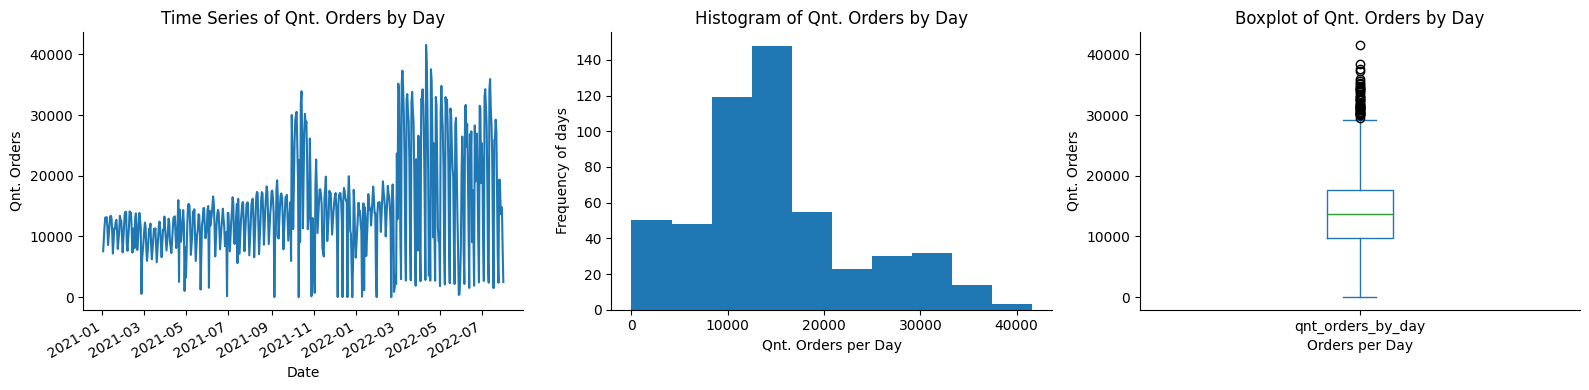

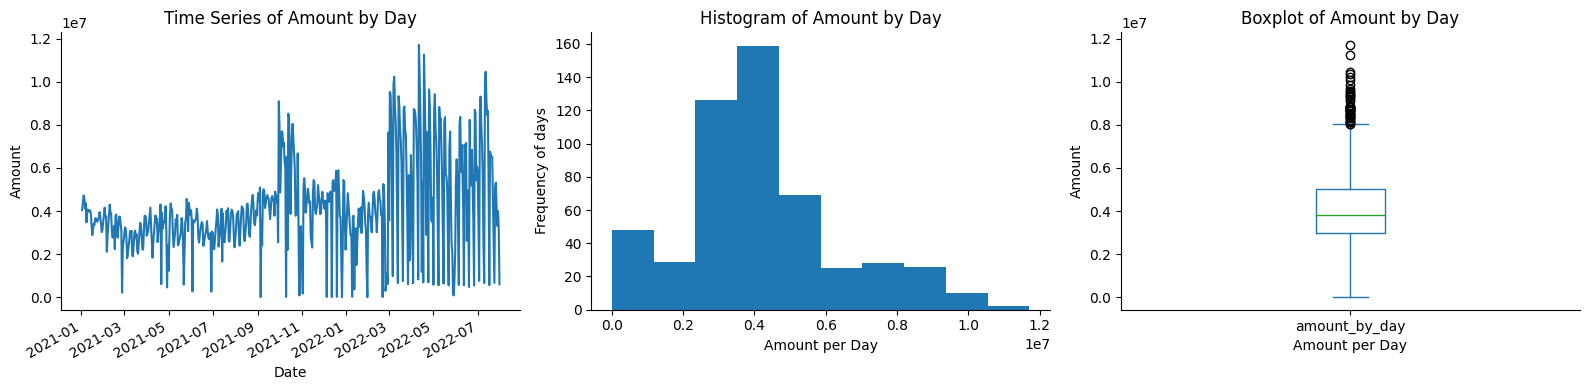

In [23]:
# @title Graphs of aggregation by days

df_plot = df_agg_by_date

plot_graphs_time_series_with_hist_and_boxplot(
    data=df_plot['qnt_orders_by_day'],
    labels={
        'line': {'title': 'Time Series of Qnt. Orders by Day', 'x_label': 'Date', 'y_label': 'Qnt. Orders'},
        'hist': {'title': 'Histogram of Qnt. Orders by Day', 'x_label': 'Qnt. Orders per Day', 'y_label': 'Frequency of days'},
        'box': {'title': 'Boxplot of Qnt. Orders by Day', 'x_label': 'Orders per Day', 'y_label': 'Qnt. Orders'}
    }
)

plot_graphs_time_series_with_hist_and_boxplot(
    data=df_plot['amount_by_day'],
    labels={
        'line': {'title': 'Time Series of Amount by Day', 'x_label': 'Date', 'y_label': 'Amount'},
        'hist': {'title': 'Histogram of Amount by Day', 'x_label': 'Amount per Day', 'y_label': 'Frequency of days'},
        'box': {'title': 'Boxplot of Amount by Day', 'x_label': 'Amount per Day', 'y_label': 'Amount'}
    }
)



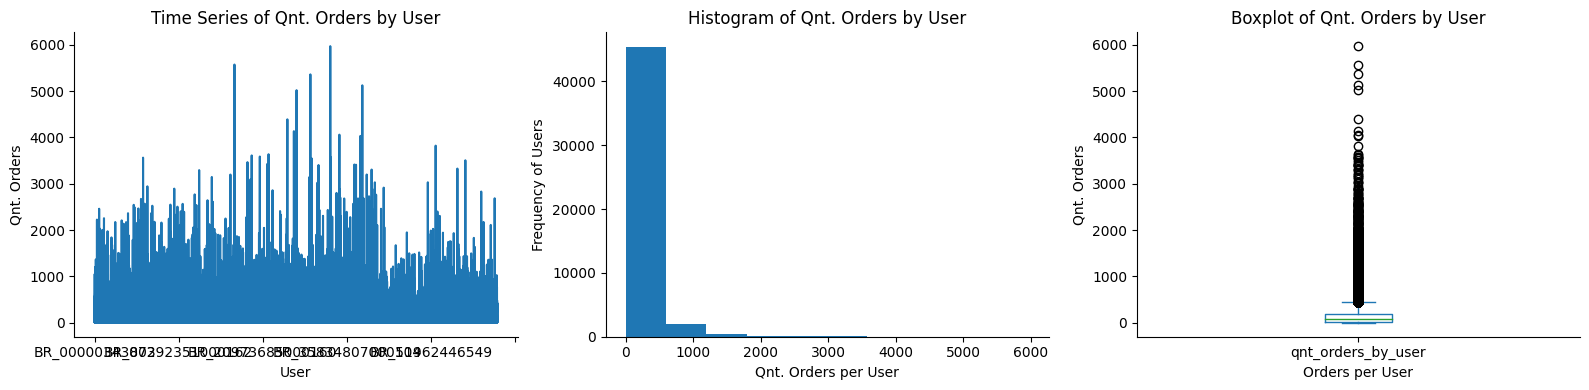

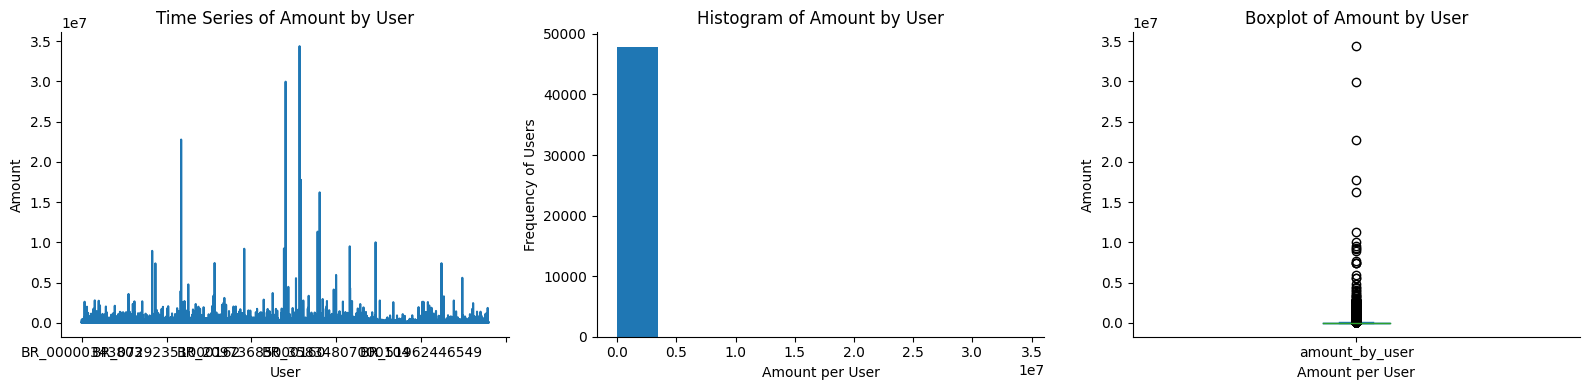

In [24]:
# @title Graphs of aggregation by User

df_plot = df_agg_by_account

# Plot for 'qnt_orders_by_user'
plot_graphs_time_series_with_hist_and_boxplot(
    data=df_plot['qnt_orders_by_user'],
    labels={
        'line': {'title': 'Time Series of Qnt. Orders by User', 'x_label': 'User', 'y_label': 'Qnt. Orders'},
        'hist': {'title': 'Histogram of Qnt. Orders by User', 'x_label': 'Qnt. Orders per User', 'y_label': 'Frequency of Users'},
        'box': {'title': 'Boxplot of Qnt. Orders by User', 'x_label': 'Orders per User', 'y_label': 'Qnt. Orders'}
    }
)

# Plot for 'amount_by_user'
plot_graphs_time_series_with_hist_and_boxplot(
    data=df_plot['amount_by_user'],
    labels={
        'line': {'title': 'Time Series of Amount by User', 'x_label': 'User', 'y_label': 'Amount'},
        'hist': {'title': 'Histogram of Amount by User', 'x_label': 'Amount per User', 'y_label': 'Frequency of Users'},
        'box': {'title': 'Boxplot of Amount by User', 'x_label': 'Amount per User', 'y_label': 'Amount'}
    }
)


## Temporal Analysis

The problem of forecasting orders is inherently a time series forecasting issue due to the dependence of data points on their chronology and their interdependence.

For this temporal analysis, I performed a series decomposition along with ACF (Auto-Correlation Function) and PACF (Partial Auto-Correlation Function) analyses of the data points. This approach helps in identifying patterns related to trends, seasonality, and provides further insights.

I used the "qnt_orders_by_day" from `df_agg_by_date` for this analysis.

For ACF and PACF, I plotted:
- The graph of the series itself
- The graph of the first derivative of the series
- The graph of the series with a time lag of 7 days, assuming a weekly pattern

**Main Insights from the Decomposition Analysis:**
- The trend graph shows non-stationarity throughout the period. There is a linear increasing trend before 09/2021, a peak in orders around 09/2021, a more stable and lower mean of orders between 11/2021 and 03/2022, and a rapid but unstable increase in orders from 03/2022 onward.
- The seasonal graph, supported by the ACF graph, reveals a weekly seasonal pattern, with peaks in orders around and just after weekends.
- The residuals graph suggests three distinct residual patterns, which might indicate different modeling phases, each exhibiting characteristics closer to stationarity.

**Main Insights from the ACF and PACF:**
- The initial ACF and PACF plots show seasonality in the series with a period of 7 days, which is more pronounced in the first difference.
- The ACF and PACF graphs with a lag of seven days reveal strong correlations between the current value and the values from the same day of the previous weeks.
- This information can help in defining parameters for models such as SARIMA.


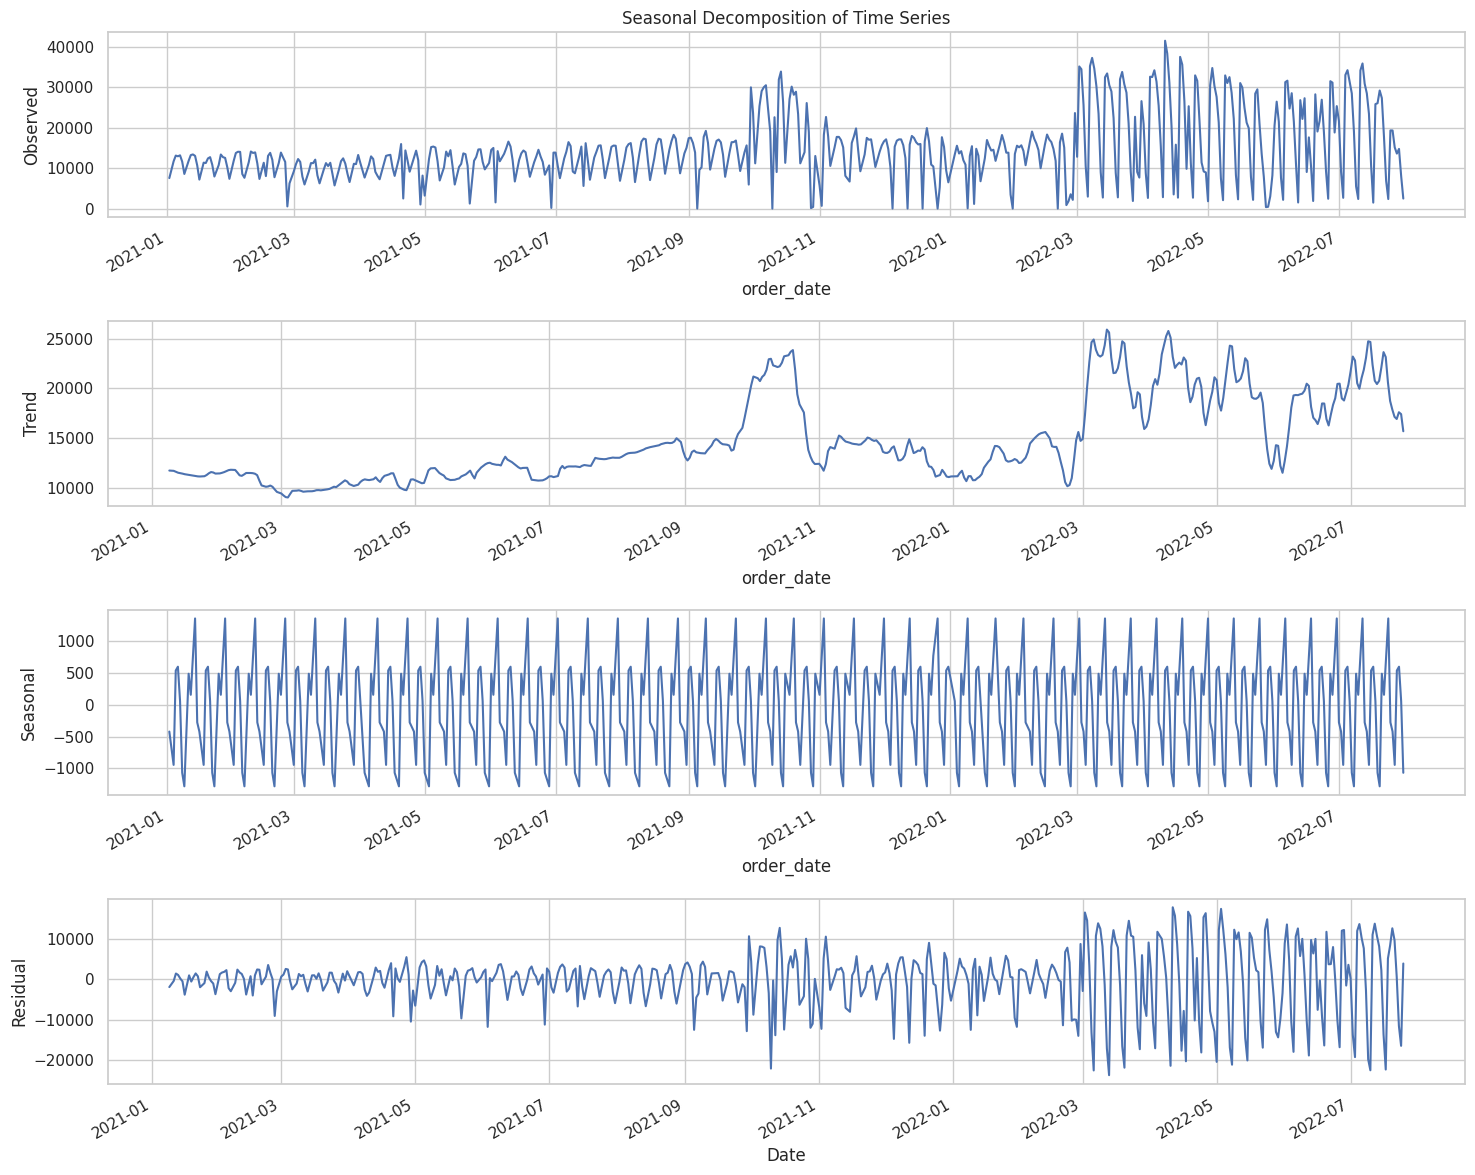

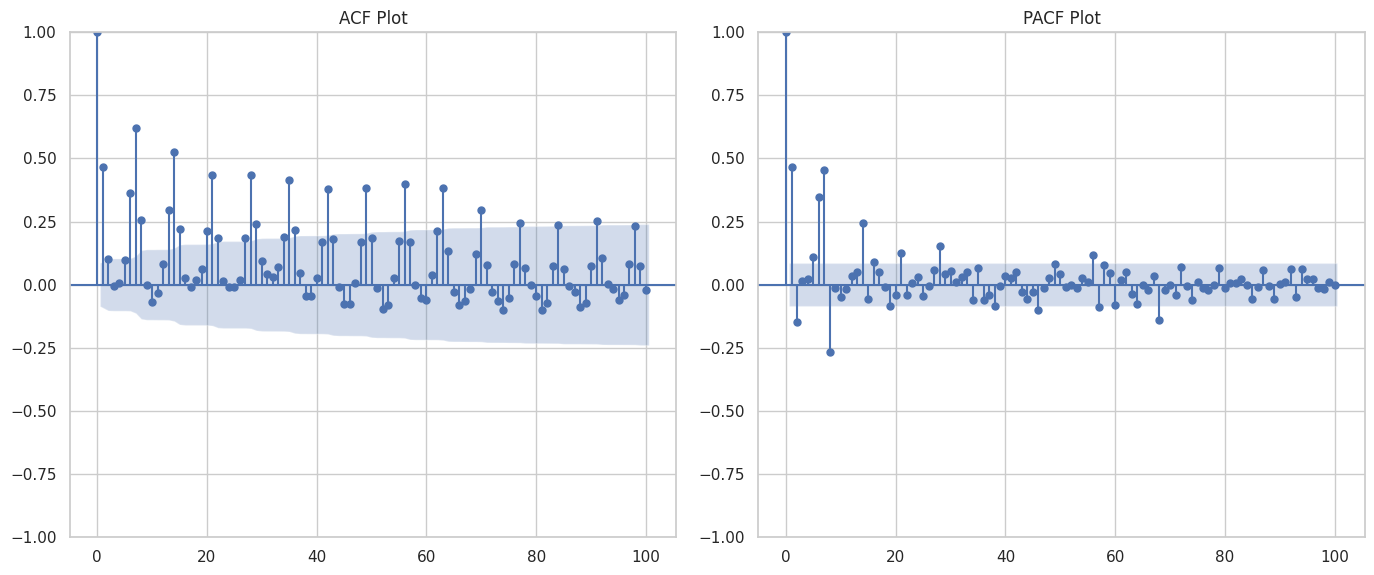

In [36]:
# @title Series seasonal decompose

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time


# Set seaborn style for the plots
sns.set(style="whitegrid")

# Extract the time series data for decomposition
df_X_arima = df_agg_by_date[['qnt_orders_by_day']]

# Adjusting the size and style of the plots
plt.rc('figure', figsize=(14, 8))
plt.rc('font', size=15)

# Perform seasonal decomposition
result = seasonal_decompose(df_X_arima, model='additive', period=12)

# Plot the decomposition components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
ax1.set_title('Seasonal Decomposition of Time Series')

result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
ax4.set_xlabel('Date')

plt.tight_layout()
plt.show()


# Create subplots with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot ACF on the first subplot
plot_acf(df_X_arima, lags=100, ax=ax[0])
ax[0].set_title('ACF Plot')

# Plot PACF on the second subplot
plot_pacf(df_X_arima, lags=100, ax=ax[1])
ax[1].set_title('PACF Plot')

# Show plots
plt.tight_layout()
plt.show()


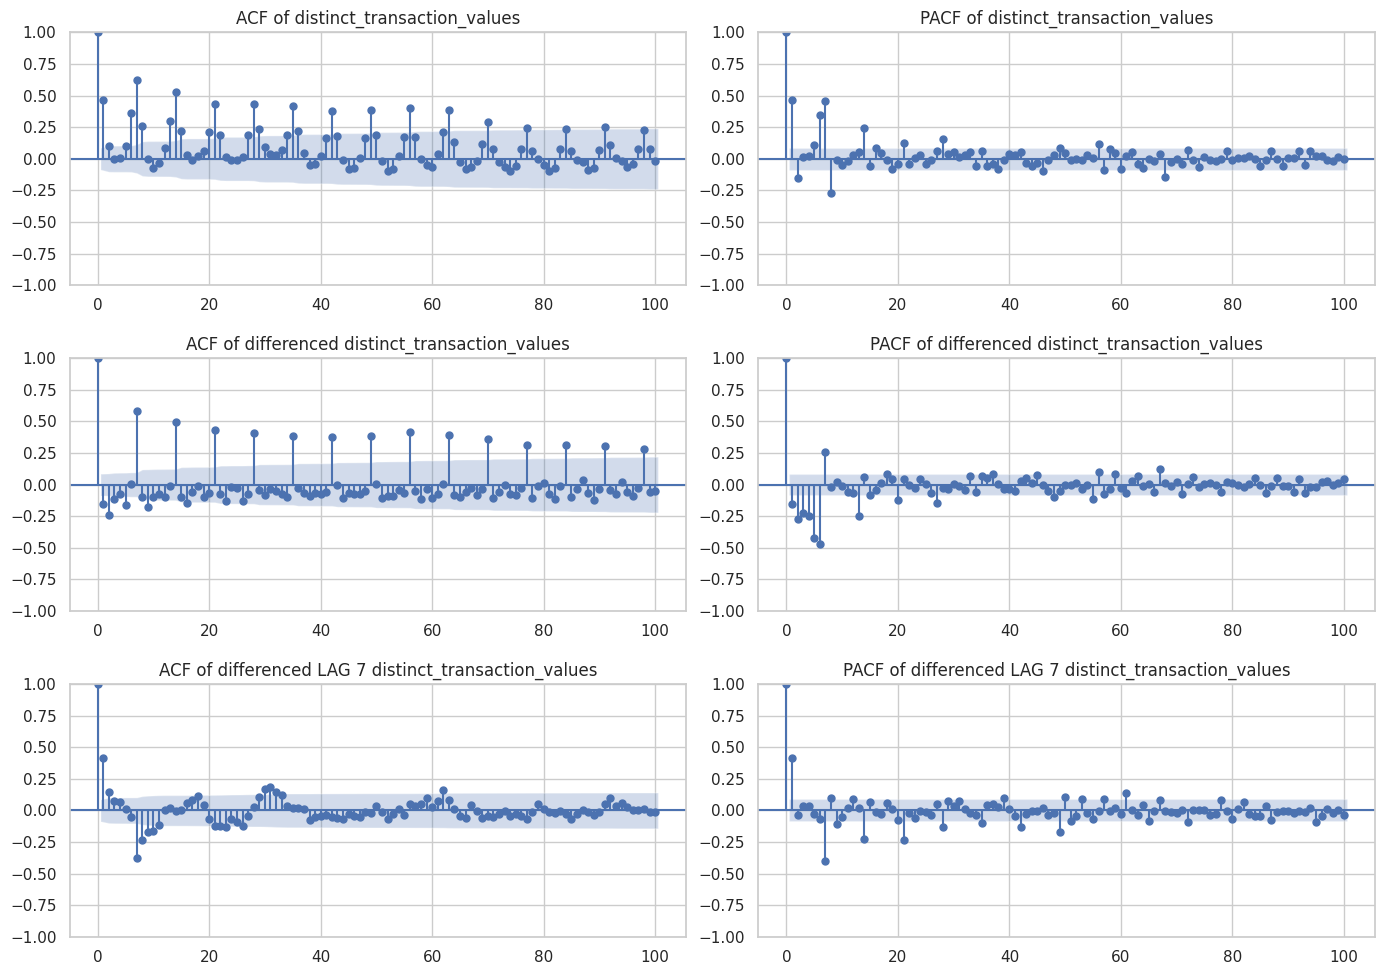

In [37]:
# @title ACF and PACF

df_X_arima = df_agg_by_date[['qnt_orders_by_day']]

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# ACF and PACF for the original time series
df_series = df_X_arima
df_diff_series = df_series.diff().dropna()
df_diff_series_lag7 = df_series.diff(7).dropna()

plot_acf(df_series, lags=100, ax=axes[0, 0])
axes[0, 0].set_title('ACF of distinct_transaction_values')

plot_pacf(df_series, lags=100, ax=axes[0, 1])
axes[0, 1].set_title('PACF of distinct_transaction_values')

# ACF and PACF for the differenced time series

plot_acf(df_diff_series, lags=100, ax=axes[1, 0])
axes[1, 0].set_title('ACF of differenced distinct_transaction_values')

plot_pacf(df_diff_series, lags=100, ax=axes[1, 1])
axes[1, 1].set_title('PACF of differenced distinct_transaction_values')


# ACF and PACF for the differenced time series - LAG 07

plot_acf(df_diff_series_lag7, lags=100, ax=axes[2, 0])
axes[2, 0].set_title('ACF of differenced LAG 7 distinct_transaction_values')

plot_pacf(df_diff_series_lag7, lags=100, ax=axes[2, 1])
axes[2, 1].set_title('PACF of differenced LAG 7 distinct_transaction_values')


# Show all plots together
plt.tight_layout()
plt.show()

## Timestamp Analysis

During the analysis, a clear weekly seasonal pattern in the data was observed. To address this, I utilized additional temporal information such as week, week year, and month to represent the dataset accurately. I created two function widly use for help in this.

- `calculate_period_columns`: Adds extra temporal information and fills missing dates.
- `plot_4week_period`: Visualizes the data with additional time-based context and forecasts over a 4-week period.

To simplify the analysis, considering that months can have varying lengths (28, 30, or 31 days), **I decided to standardize the forecasting period to 4 weeks, or 28 days**.


Data with trasnformation:


,qnt_orders_by_day
order_date,
2021-01-02,7554
2021-01-04,11704
2021-01-05,13122
2021-01-06,12955
2021-01-07,13189


Data with date trasnformation:


,order_date,year,week_in_year,year_four_week_period,four_week_period,month_in_year,qnt_orders_by_day
0,2021-01-02,2021,53,2021_W14,14,1,7554
1,2021-01-04,2021,1,2021_W1,1,1,11704
2,2021-01-05,2021,1,2021_W1,1,1,13122
3,2021-01-06,2021,1,2021_W1,1,1,12955
4,2021-01-07,2021,1,2021_W1,1,1,13189


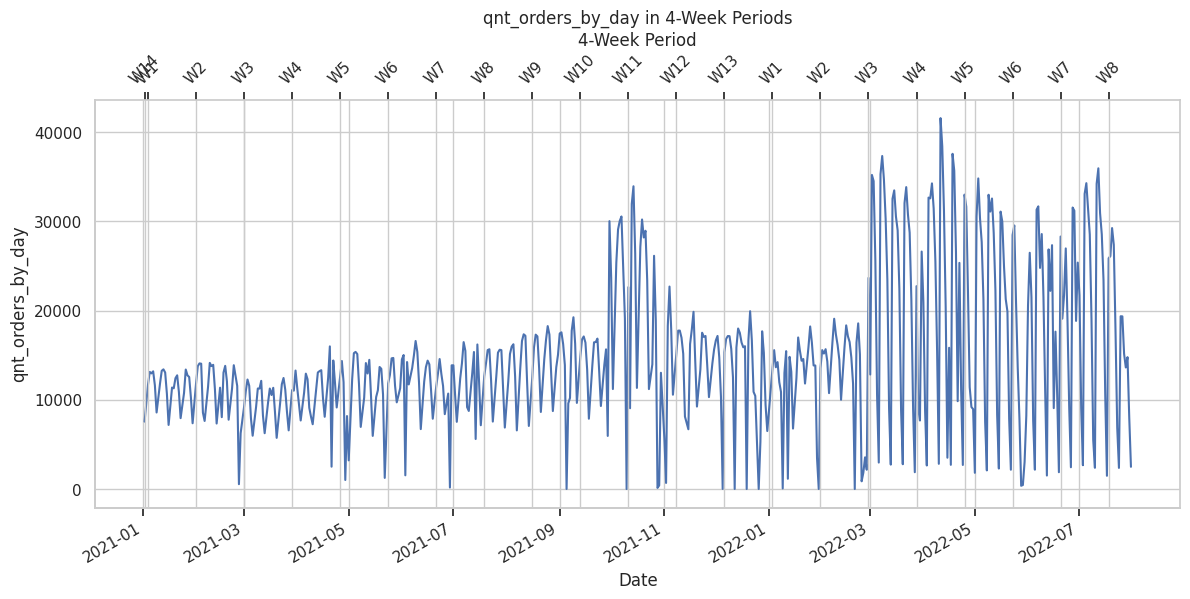

In [49]:
COLUMNS_TARGET='qnt_orders_by_day'
df_X = df_agg_by_date[[COLUMNS_TARGET]]
df_X_date_transform = calculate_period_columns(df_X)

print("Data with trasnformation:")
display(df_X.head())

print("Data with date trasnformation:")
display(df_X_date_transform.head())



# Example usage:
settings = {
    'title': f'{COLUMNS_TARGET} in 4-Week Periods',
    'xlabel': 'Date',
    'ylabel': f'{COLUMNS_TARGET}'
}
plot_4week_period(df_X_date_transform, 'qnt_orders_by_day', settings, df_naive=None, df_true=None, df_predict=None)

## Initial Hypotesis

In the graph below, analyzing the quantity of orders and amount by user, we can observe that there are some peaks in the number of orders for certain users (similar to the time series graphs). The histogram and boxplots show that the distribution of the data is highly skewed.

Because of this, my initial insight was to separate the clients into two groups, allowing us to analyze these two groups of clients in different ways.

# Defining the Business Problem

In this section, I revisit the business problem and define the metrics to analyze for the purpose of forecasting monthly sales.


# Next steps:

This text shows point that i suggeste to deal in next analysis.

1 - in df_complete_historical_orders, we used drop_duplicate keeping the first duplicated. Maybe it could be a good point to analyse deeper, because a duplicated order could happen in same day. Suggestions: look for the timestamp, or undersatind better the processing.